In [32]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier

import optuna # A hyperparameter optimization framework
import catboost as cb
import lightgbm as lgb
import xgboost as xgb

OPTIMIZE_OPTUNA = False
SUBSAMPLE = False
SUBSAMPLE_RATIO = 0.5 # only effective if SUBSAMPLE=True
DISPLAY_FEATURE_IMPORTANCE = True

### Feature Engineering
May have to check for correlation and doing some feature selection

In [9]:
df_train = pd.read_csv('../isic-2024-challenge/train-metadata.csv')
df_test = pd.read_csv('../isic-2024-challenge/test-metadata.csv')

C:\Users\15614\AppData\Local\Temp\ipykernel_41712\3337938859.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../isic-2024-challenge/train-metadata.csv')


In [10]:
def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    # Until here.
    
    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
        
        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

In [11]:
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] 

# Fill missing values with median - probably have better ways of doing this 
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_test[num_cols] = df_test[num_cols].fillna(df_train[num_cols].median())
df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _ , _ = feature_engineering(df_test.copy())
num_cols += new_num_cols

# anatom_site_general
cat_cols = ['sex', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple'] + new_cat_cols
train_cols = num_cols + cat_cols

'''
df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
df_eff = df_eff[["target_effnetv1b0"]]

df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")
df_eva = df_eva[["target_eva02"]]

df_image_3 = pd.read_csv("/kaggle/input/isic-2024-pl-submission-script-and-preds/train_preds.csv")

df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
df_train["target_eva02"] = df_eva["target_eva02"]
df_train["target_3"] = df_image_3["pred"]

train_cols += ["target_effnetv1b0","target_eva02", "target_3"]
'''

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
) 

X_cat = category_encoder.fit_transform(df_train[cat_cols]) 
for c, cat_col in enumerate(cat_cols): 
    df_train[cat_col] = X_cat[:, c] 

### CV setup
A stratified group k-fold cross-validation
- Each fold has a representative distribution of the target variable (stratification). 
- Samples from the same group (e.g., the same patient) do not appear in both training and validation sets within a single fold. 
- Subsampling is used to balance the classes, which is usually the technique used to handle class imbalance. 

The purpose of subsampling in this context is to address class imbalance, which can cause machine learning models to be biased towards the majority class. By reducing the number of negative samples to a more balanced ratio with the positive samples, the model can learn to recognize both classes more effectively. This improves the model's performance, particularly its ability to correctly classify the minority class.

In [12]:
N_SPLITS = 5
gkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

if SUBSAMPLE:
    df_pos = df_train[df_train["target"] == 1]
    df_neg = df_train[df_train["target"] == 0]
    df_neg = df_neg.sample(frac=SUBSAMPLE_RATIO, random_state=42)
    df_train = pd.concat([df_pos, df_neg]).sample(frac=1.0, random_state=42).reset_index(drop=True)    

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

### Competition Metrics

In [13]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

def custom_lgbm_metric(y_true, y_hat):
    # TODO: Refactor with the above.
    min_tpr = 0.80
    v_gt = abs(y_true-1)
    v_pred = np.array([1.0 - x for x in y_hat])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return "pauc80", partial_auc, True

### LightGBM Model

In [14]:
def objective(trial):
    param = {
        "objective": "binary",
        # "metric": "custom",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device": "gpu"
    }
    scores = []
    for fold in range(N_SPLITS):
        _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
        _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
        dtrain = lgb.Dataset(_df_train[train_cols], label=_df_train["target"])
        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(_df_valid[train_cols])
        score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
        scores.append(score)
    return np.mean(scores)

In [15]:
if OPTIMIZE_OPTUNA:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [26]:
new_params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 0.0004681884533249742, 
    'lambda_l2': 8.765240856362274, 
    'num_leaves': 136, 
    'feature_fraction': 0.5392005444882538, 
    'bagging_fraction': 0.9577412548866563, 
    'bagging_freq': 6,
    'min_child_samples': 60,
    "device": "gpu"
}
lgb_scores = []
lgb_models = []
oof_df = pd.DataFrame()
for fold in range(N_SPLITS):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMClassifier(**new_params)
    # model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params)) for i in range(3)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    lgb_models.append(model)
    oof_single = _df_valid[["isic_id", "target"]].copy()
    oof_single["pred"] = preds
    oof_df = pd.concat([oof_df, oof_single])

fold: 0 - Partial AUC Score: 0.16416
fold: 1 - Partial AUC Score: 0.16717
fold: 2 - Partial AUC Score: 0.17472
fold: 3 - Partial AUC Score: 0.13731
fold: 4 - Partial AUC Score: 0.15263


In [27]:
lgbm_score = comp_score(oof_df["target"], oof_df["pred"], "")
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.15715


#### LightGBM feature importance

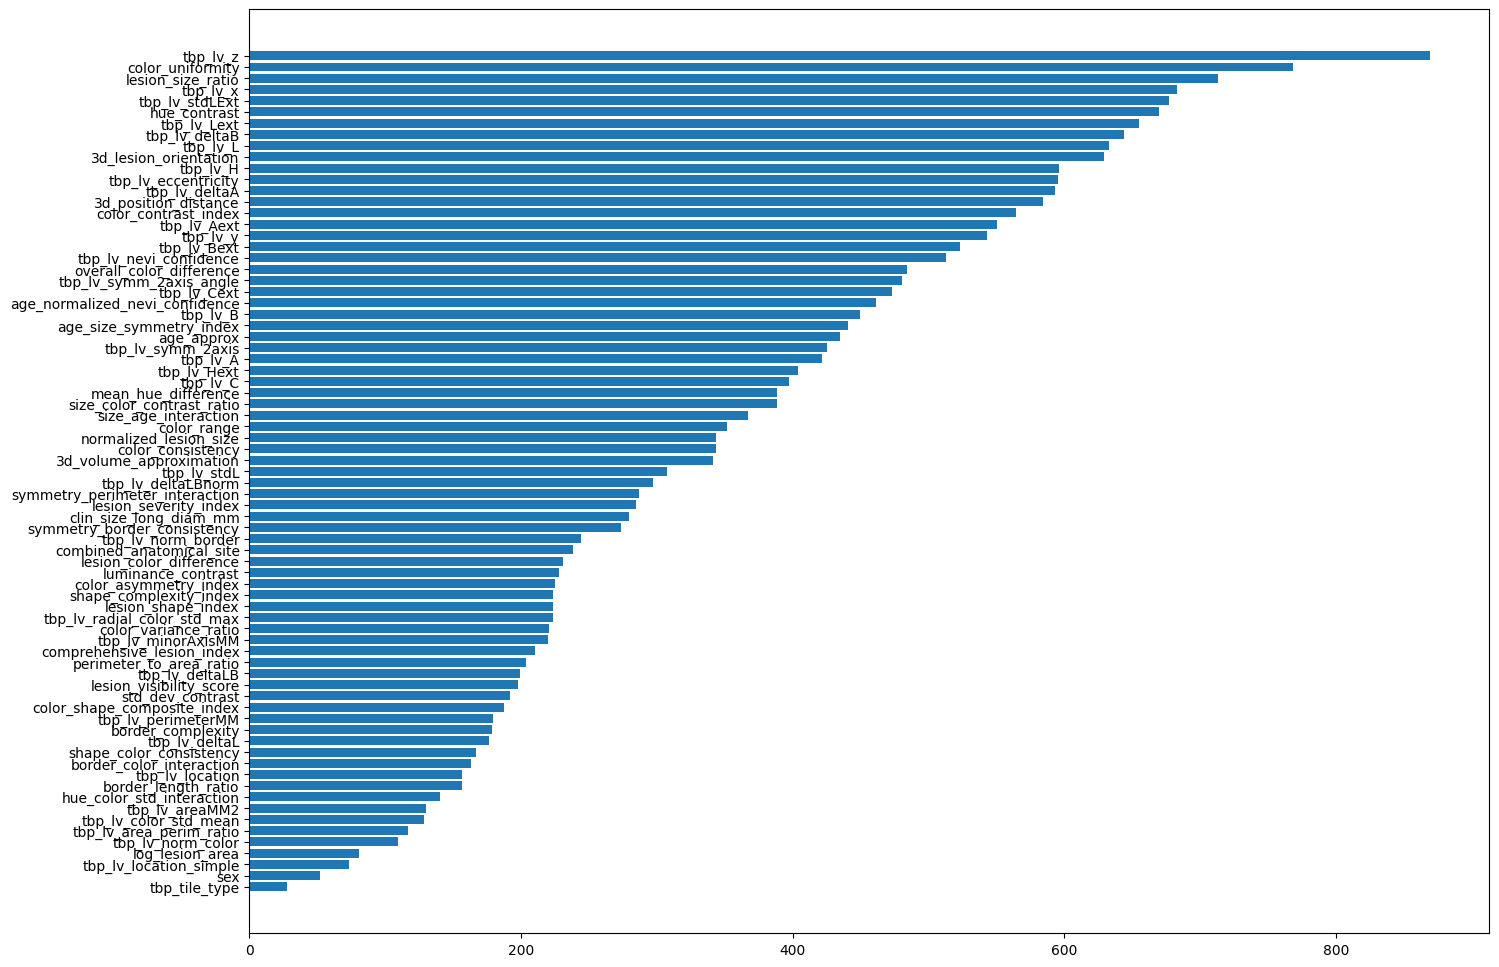

In [28]:
if DISPLAY_FEATURE_IMPORTANCE:
    # Make sure that this is a single model, not voting classifier. Will handle that later on.
    importances = np.mean([model.feature_importances_ for model in lgb_models], 0)
    df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)

    plt.figure(figsize=(16, 12))
    plt.barh(df_imp["feature"], df_imp["importance"])
    plt.show()

### CatBoost

In [33]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "task_type": "GPU",
        # "used_ram_limit": "3gb",
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    scores = []
    for fold in range(N_SPLITS):
        _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
        _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
        gbm = cb.CatBoostClassifier(**param)
        gbm.fit(_df_train[train_cols], _df_train["target"], eval_set=[(_df_valid[train_cols], _df_valid["target"])], verbose=0, early_stopping_rounds=100)
        preds = gbm.predict(_df_valid[train_cols])
        score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
        scores.append(score)
    return np.mean(scores)

In [34]:
if OPTIMIZE_OPTUNA:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=600)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [36]:
cb_params = {
    'objective': 'Logloss',
    # "random_state": 42,
    # "colsample_bylevel": 0.3, # 0.01, 0.1
    "iterations": 400,
    "learning_rate": 0.05,
    "cat_features": cat_cols,
    "max_depth": 8,
    "l2_leaf_reg": 5,
    "task_type": "GPU",
    # "scale_pos_weight": 2,
    "verbose": 0,
}
cb_scores = []
cb_models = []
for fold in range(N_SPLITS):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = cb.CatBoostClassifier(**cb_params)
    # model = VotingClassifier([(f"cb_{i}", cb.CatBoostClassifier(random_state=i, **cb_params)) for i in range(3)], voting="soft")
    # eval_set=(_df_valid[train_cols], _df_valid["target"]), early_stopping_rounds=50
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    cb_scores.append(score)
    cb_models.append(model)

fold: 0 - Partial AUC Score: 0.15361
fold: 1 - Partial AUC Score: 0.16568
fold: 2 - Partial AUC Score: 0.18055
fold: 3 - Partial AUC Score: 0.14274
fold: 4 - Partial AUC Score: 0.15403


In [37]:
cb_score = np.mean(cb_scores)
print(f"CatBoost Score: {cb_score:.5f}")

CatBoost Score: 0.15932


#### CatBoost Feature Importance

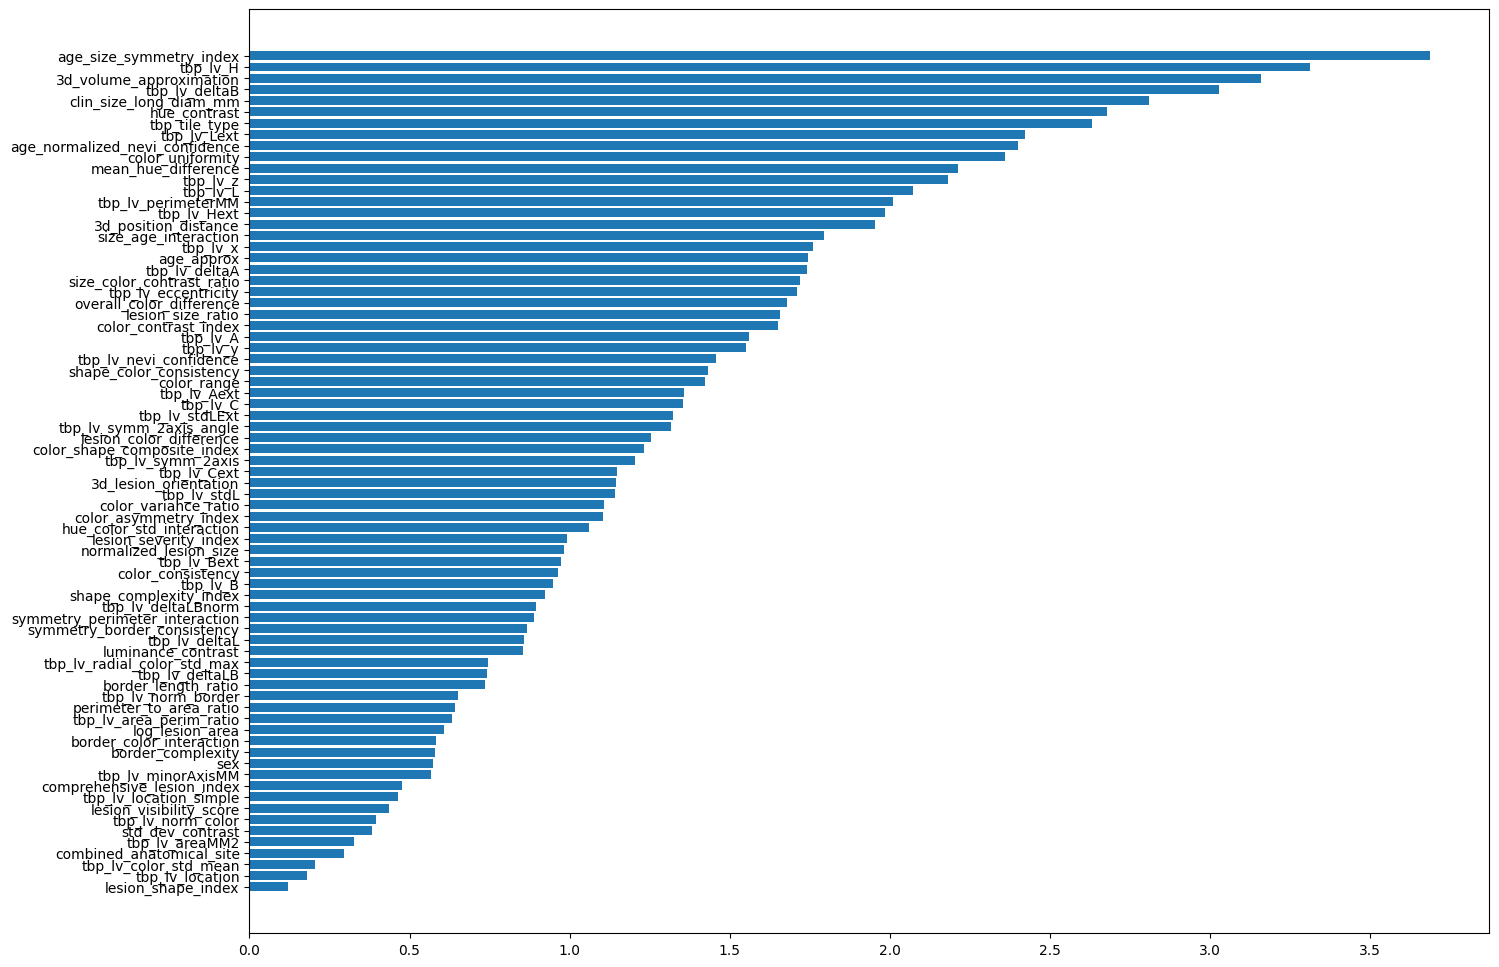

In [38]:
if DISPLAY_FEATURE_IMPORTANCE:
    # Same here.
    importances = np.mean([model.feature_importances_ for model in cb_models], 0)
    df_imp = pd.DataFrame({"feature": model.feature_names_, "importance": importances}).sort_values("importance").reset_index(drop=True)

    plt.figure(figsize=(16, 12))
    plt.barh(df_imp["feature"], df_imp["importance"])
    plt.show()

### Ensemble

In [39]:
X_cat = category_encoder.transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [40]:
lgb_preds = np.mean([model.predict_proba(df_test[train_cols])[:, 1] for model in lgb_models], 0)
cb_preds = np.mean([model.predict_proba(df_test[train_cols])[:, 1] for model in cb_models], 0)
preds = lgb_preds * 0.5 + cb_preds * 0.5

In [42]:
df_sub = pd.read_csv("../isic-2024-challenge/sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.000080
1,ISIC_0015729,0.000021
2,ISIC_0015740,0.000144
